# **PROJET BIO-INFO : L'impact de la hausse des températures sur la puissance des ouragans**

# Membres du groupe:

- Anderson TESS
- Fiacre MITOKPE
- Kenny RUFFINE
- Gneneman Stéphane Jean-Baptiste KONÉ 

In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install polyfit

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import folium
import requests
from bs4 import BeautifulSoup
import xarray as xr
import tempfile
import os
!pip install folium

In [6]:
#Dataset sur les cyclones (certaines lignes ont plus de virgules, c'est pourquoi on "skip" dans les bad_lines)
df2 = pd.read_csv("storms.csv", sep=",", engine="python", on_bad_lines="skip")
df2_copy = df2
df2 = df2.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter", "pressure"]) # colonnes qu'on veut supprimer
df2_copy = df2_copy.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter"])
df2 = df2[df2["status"] == "hurricane"] # on regarde que les ouragans pour le moment
df2_copy = df2_copy[df2_copy["status"] == "hurricane"] # on regarde que les ouragans pour le moment


# On garde que les moments min et max du vent pour chaque ouragan
df2["wind"] = pd.to_numeric(df2["wind"], errors="coerce")
df2_copy["wind"] = pd.to_numeric(df2_copy["wind"], errors="coerce")
df2_copy

,name,year,month,day,hour,lat,long,status,category,wind,pressure
44,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65,987
45,Blanche,1975,7,27,12,36.9,-69.0,hurricane,1.0,70,984
46,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75,981
47,Blanche,1975,7,28,0,39.3,-67.2,hurricane,1.0,75,980
48,Blanche,1975,7,28,6,41.2,-66.4,hurricane,1.0,70,980
...,...,...,...,...,...,...,...,...,...,...,...
19504,Martin,2022,11,3,6,40.3,-43.6,hurricane,1.0,75,965
19526,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65,980
19527,Nicole,2022,11,10,0,26.7,-78.4,hurricane,1.0,65,980
19528,Nicole,2022,11,10,6,27.3,-79.8,hurricane,1.0,65,980


In [7]:
# MAX WIND SPEEDS
df2_max = df2.loc[df2.groupby(["name","year"])["wind"].idxmax()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_max = df2_max.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_max = df2_max.reset_index(drop=True)

# on affiche le dataset
df2_max

,name,year,month,day,hour,lat,long,status,category,wind
0,Caroline,1975,8,31,0,24.0,-97.0,hurricane,3.0,100
1,Gladys,1975,10,2,12,35.3,-69.8,hurricane,4.0,120
2,Faye,1975,9,27,0,32.7,-64.2,hurricane,2.0,90
3,Eloise,1975,9,23,12,30.2,-86.3,hurricane,3.0,110
4,Doris,1975,9,2,6,36.4,-44.5,hurricane,2.0,95
...,...,...,...,...,...,...,...,...,...,...
314,Bonnie,2022,7,5,12,15.1,-103.8,hurricane,3.0,100
315,Martin,2022,11,2,18,36.1,-48.9,hurricane,1.0,75
316,Lisa,2022,11,2,21,17.4,-88.3,hurricane,1.0,80
317,Danielle,2022,9,4,18,38.4,-45.2,hurricane,1.0,75


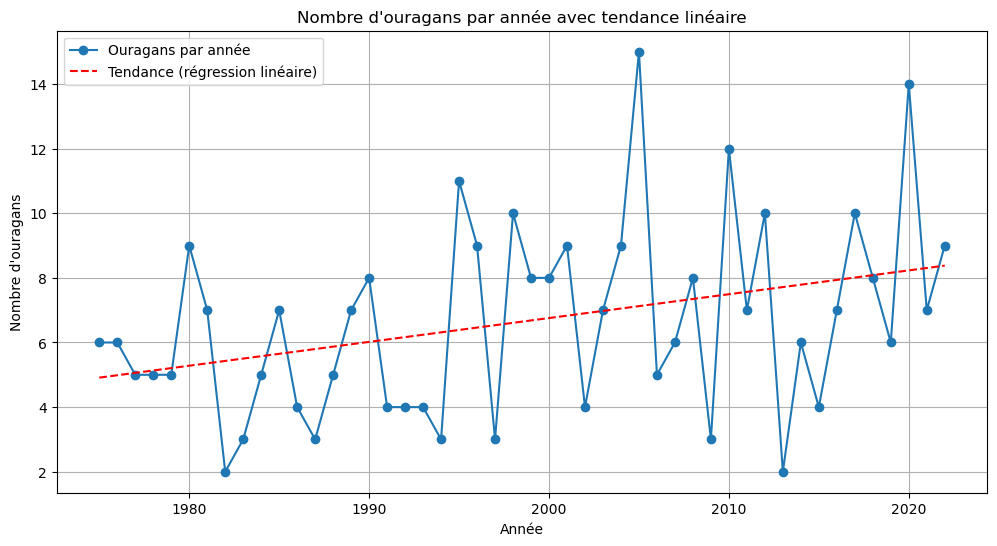

In [8]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_max["year"].value_counts().sort_index()

# Conversion des données en tableaux numpy
x = hurricanes_per_year.index.values  # Années
y = hurricanes_per_year.values        # Nombre d'ouragans

# Ajustement d'une régression linéaire (droite de tendance)
coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale

# Générer les valeurs prédites pour tracer la droite
x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
y_smooth = linear_trend(x_smooth)

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")

# Ajout de la droite de tendance
plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")

# Ajout des labels et du titre
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année avec tendance linéaire")
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

In [9]:

# MIN WIND SPEEDS
df2_min = df2.loc[df2.groupby(["name","year"])["wind"].idxmin()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_min = df2_min.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_min = df2_min.reset_index(drop=True)

# on affiche le dataset
df2_min


,name,year,month,day,hour,lat,long,status,category,wind
0,Caroline,1975,8,30,0,23.3,-94.2,hurricane,1.0,65
1,Gladys,1975,9,25,18,15.8,-44.0,hurricane,1.0,65
2,Faye,1975,9,26,0,26.5,-60.0,hurricane,1.0,65
3,Eloise,1975,9,16,18,19.5,-68.4,hurricane,1.0,65
4,Doris,1975,8,31,0,34.9,-46.3,hurricane,1.0,65
...,...,...,...,...,...,...,...,...,...,...
314,Bonnie,2022,7,4,0,12.9,-94.9,hurricane,1.0,65
315,Martin,2022,11,2,12,35.1,-50.9,hurricane,1.0,65
316,Lisa,2022,11,3,0,17.5,-88.6,hurricane,1.0,65
317,Danielle,2022,9,2,12,37.8,-43.6,hurricane,1.0,65


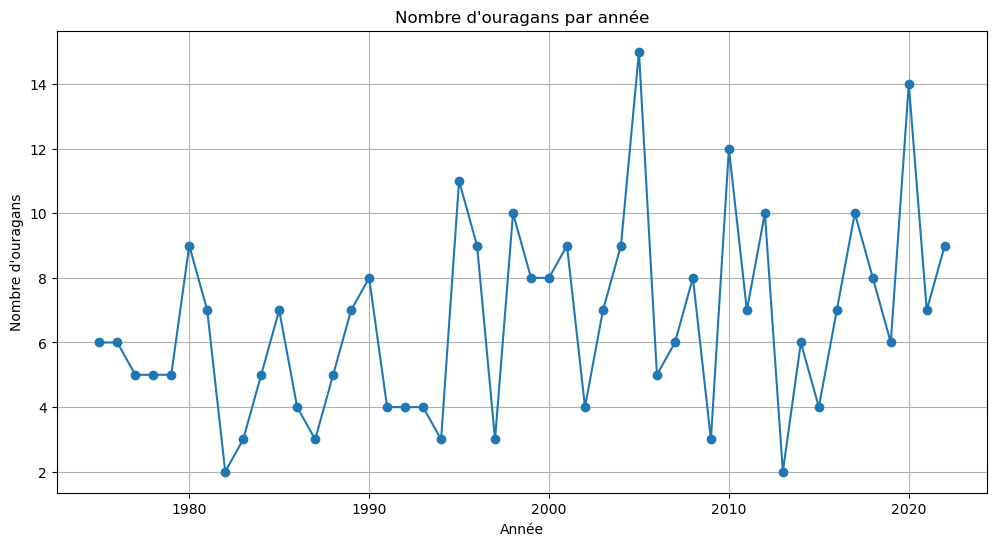

In [10]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_min["year"].value_counts().sort_index()

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(hurricanes_per_year.index, hurricanes_per_year.values, marker='o', linestyle='-')
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année")
plt.grid(True)
plt.show()

In [11]:

def get_hurricane_year_by_index(df, index):
    """
    retourne une seule ligne du dataset en fonction de l'indice donné en paramètre.

    Paramètres:
    df (DataFrame): dataset des ouragans.
    index (int): indice de la ligne à recupérer.

    Returns:
    str : Une str Pandas contenant l'année, le mois, le jour, la latitude, la longitude et la catégorie, 
            ou un message d'erreur si l'index dépasse la taille du dataset.
    """

    required_columns = {"year"}

    if not required_columns.issubset(df.columns):
        return "Error: The dataset does not contain all the required columns."

    if index < 0 or index >= len(df):
        return "Error: Index out of range."

    return int(df.loc[index, ["year"]])

print("\n")
index = 43 #1982 
index2 = 102 #1995 
index3 = 162 #2002
index4 = 190 #2005 
index5 = 228 #2010 
index6 = 247 #2013 
index7 = 300 #2020 
hurricane_year1 = get_hurricane_year_by_index(df2_max, index)
hurricane_year2 = get_hurricane_year_by_index(df2_max, index2)
hurricane_year3 = get_hurricane_year_by_index(df2_max, index3)
hurricane_year4 = get_hurricane_year_by_index(df2_max, index4)
hurricane_year5 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year6 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year7 = get_hurricane_year_by_index(df2_max, index7)
print(hurricane_year1)
print("\n")
print(hurricane_year2)
print("\n")
print(hurricane_year3)
print("\n")
print(hurricane_year4)
print("\n")
print(hurricane_year5)
print("\n")
print(hurricane_year6)
print("\n")
print(hurricane_year7)
print("\n")






1982


1995


2002


2005


2010


2010


2020




/tmp/ipykernel_1845/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/tmp/ipykernel_1845/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/tmp/ipykernel_1845/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/tmp/ipykernel_1845/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/tmp/ipykernel_1845/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the 

In [12]:


def plot_hurricane_on_map_with_category(df):
    """
    Affiche les positions des cyclones (latitude, longitude) sur une carte interactive avec une icône
    correspondant à la catégorie de chaque ouragan.
    
    Parameters:
    df (DataFrame): Le dataset des cyclones avec des colonnes 'lat', 'long' et 'category'.
    
    Returns:
    folium.Map: Carte interactive affichant les cyclones avec des icônes basées sur leur catégorie.
    """
    # Créer une carte centrée autour d'un point par défaut (ici, centre de l'océan Atlantique)
    hurricane_map = folium.Map(location=[20, -50], zoom_start=3)

    # Vérifier que les colonnes nécessaires existent dans le DataFrame
    if 'lat' in df.columns and 'long' in df.columns and 'category' in df.columns:
        # Dictionnaire pour associer une couleur à chaque catégorie
        category_colors = {
            1: 'blue',     # Catégorie 1 
            2: 'green',    # Catégorie 2
            3: 'orange',   # Catégorie 3 
            4: 'red',   # Catégorie 4 
            5: 'black'       # Catégorie 5  
        }
        
        # Ajouter un marqueur pour chaque cyclone en fonction de la latitude et la longitude)
        for index, row in df.iterrows():
            category = row['category']
            color = category_colors.get(category, 'gray')  # Utiliser 'gray' par défaut si la catégorie est inconnue
            
            folium.Marker(
                location=[row['lat'], row['long']],
                popup=f"Name : {row['name']}, Year: {row['year']}, Month: {row['month']}, Day: {row['day']}, Category: {category}",
                icon=folium.Icon(color=color, icon='info-sign')
            ).add_to(hurricane_map)
    else:
        print("Erreur : Les colonnes 'lat', 'long' et 'category' sont nécessaires dans le DataFrame.")
    
    
    return hurricane_map


hurricane_map = plot_hurricane_on_map_with_category(df2_max)
hurricane_map



    

In [13]:
#La fonction pour afficher l'évolution de la forces des vents
##Pour chaque année, on calcule la moyenne de la force des vents
mean_of_wind_per_year = df2.groupby('year')['wind'].mean().reset_index()
mean_of_wind_per_year


,year,wind
0,1975,79.329268
1,1976,79.326923
2,1977,80.384615
3,1978,86.976744
4,1979,88.372093
5,1980,87.516340
6,1981,82.444444
7,1982,87.391304
8,1983,75.312500
9,1984,75.472973


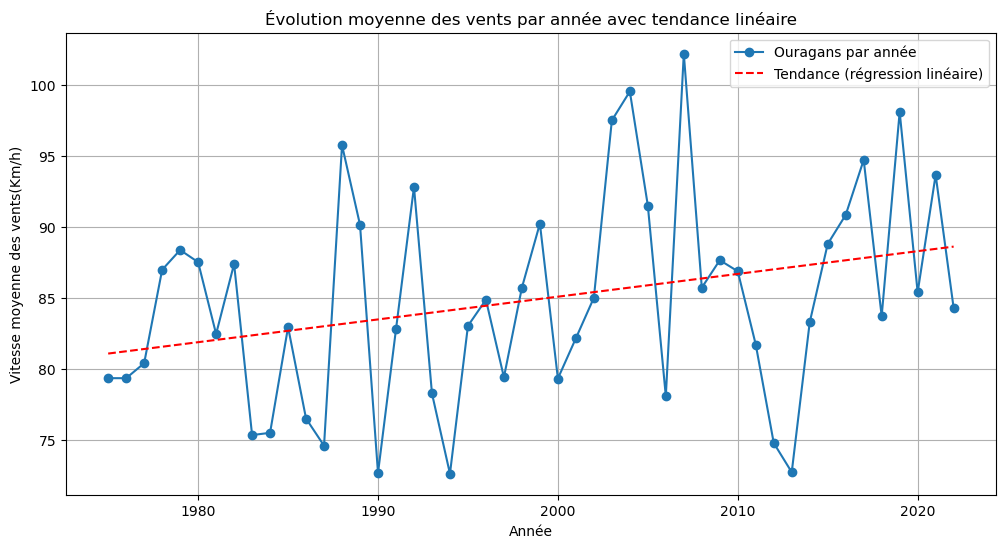

In [14]:

def affichage_moy_vents(df):
    #conversion des données en tableaux numpy
    x = mean_of_wind_per_year['year']  # Années
    y = mean_of_wind_per_year['wind']        # Vent
    
    #ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    #générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    #tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")
    
    
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    
    plt.xlabel("Année")
    plt.ylabel("Vitesse moyenne des vents(Km/h)")
    plt.legend()
    plt.title("Évolution moyenne des vents par année avec tendance linéaire")
    plt.grid(True)
    
    # Affichage du graphique
    plt.show()

affichage_moy_vents(mean_of_wind_per_year)

In [15]:
#La fonction pour afficher l'évolution de la catégorie des ouragans
##Pour chaque année, on calcule la moyenne de la catégorie des ouragans
mean_of_category_per_year = df2.groupby('year')['category'].mean().reset_index()
mean_of_category_per_year

,year,category
0,1975,1.487805
1,1976,1.480769
2,1977,1.576923
3,1978,1.906977
4,1979,2.000000
5,1980,1.928105
6,1981,1.644444
7,1982,1.869565
8,1983,1.375000
9,1984,1.270270


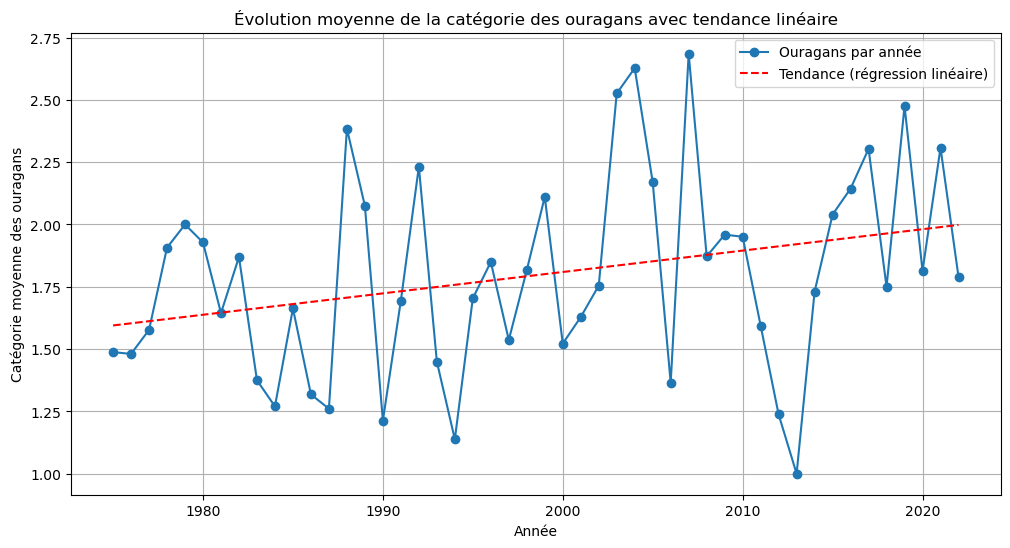

In [16]:

def affiche_moy_cat(df):
    #conversion des données en tableaux numpy
    x = mean_of_category_per_year['year']  # Années
    y = mean_of_category_per_year['category']        # Vent
    
    #ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    #générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    #tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")
    
    #droite de tendance
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    plt.xlabel("Année")
    plt.ylabel("Catégorie moyenne des ouragans")
    plt.legend()
    plt.title("Évolution moyenne de la catégorie des ouragans avec tendance linéaire")
    plt.grid(True)
    

    plt.show()

affiche_moy_cat(mean_of_category_per_year)

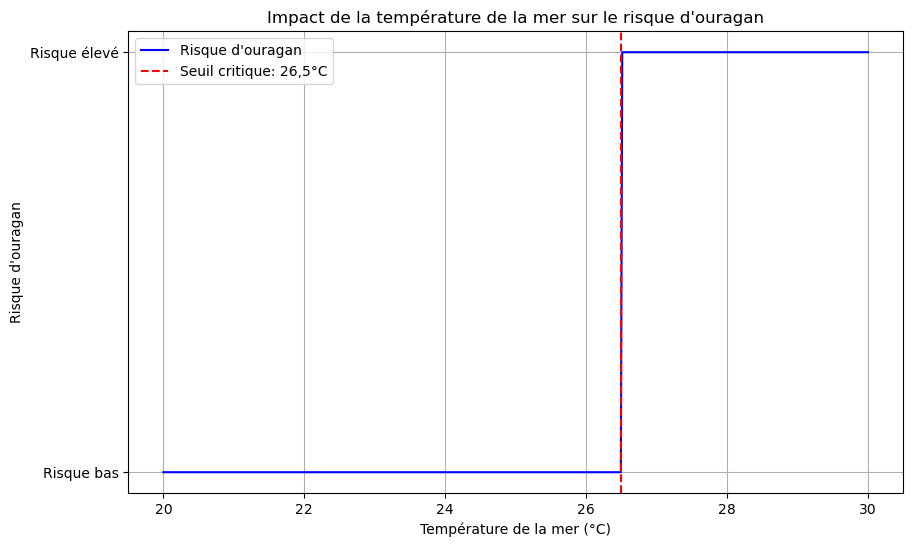

In [70]:
# Générer une plage de températures de la mer allant de 20°C à 30°C
temperatures = np.linspace(20, 30, 500)

# Définir le seuil critique pour le risque d'ouragan
seuil = 26.5

risque_numeric = np.where(temperatures >= seuil, 1, 0)

# Création de la figure
plt.figure(figsize=(10, 6))

# Tracé de la courbe du risque en fonction de la température
plt.plot(temperatures, risque_numeric, label="Risque d'ouragan", color='blue')

plt.axvline(seuil, color='red', linestyle='--', label="Seuil critique: 26,5°C")

# Configuration des axes
plt.xlabel("Température de la mer (°C)")
plt.ylabel("Risque d'ouragan")
plt.title("Impact de la température de la mer sur le risque d'ouragan")


plt.yticks([0, 1], ["Risque bas", "Risque élevé"])

plt.legend()
plt.grid(True)
plt.show()

In [71]:

def verify_files():
    # Vérification du fichier CSV
    csv_file = "storms.csv"
    if os.path.exists(csv_file):
        print(f"Le fichier CSV '{csv_file}' a été trouvé.")
        # Affichage rapide des premières lignes
        df = pd.read_csv(csv_file)
        print("Aperçu du fichier CSV :")
        print(df.head())
    else:
        print(f"Le fichier CSV '{csv_file}' n'a pas été trouvé.")
    
    # Vérification du fichier NetCDF pour 1981
    nc_file = "sst.day.mean.2002.nc"
    if os.path.exists(nc_file):
        print(f"\nLe fichier NetCDF '{nc_file}' a été trouvé.")
        ds = xr.open_dataset(nc_file)
        print("Variables disponibles dans le fichier NetCDF :", list(ds.data_vars))
        print("Coordonnées disponibles :", list(ds.coords))
    else:
        print(f"Le fichier NetCDF '{nc_file}' n'a pas été trouvé.")

if __name__ == "__main__":
    verify_files()


Le fichier CSV 'storms.csv' a été trouvé.
Aperçu du fichier CSV :
  name  year  month  day  hour   lat  long               status  category  \
0  Amy  1975      6   27     0  27.5 -79.0  tropical depression       NaN   
1  Amy  1975      6   27     6  28.5 -79.0  tropical depression       NaN   
2  Amy  1975      6   27    12  29.5 -79.0  tropical depression       NaN   
3  Amy  1975      6   27    18  30.5 -79.0  tropical depression       NaN   
4  Amy  1975      6   28     0  31.5 -78.8  tropical depression       NaN   

   wind  pressure  tropicalstorm_force_diameter  hurricane_force_diameter  
0    25      1013                           NaN                       NaN  
1    25      1013                           NaN                       NaN  
2    25      1013                           NaN                       NaN  
3    25      1013                           NaN                       NaN  
4    25      1012                           NaN                       NaN  
Le fichier NetC

In [72]:

def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') à l'aide des coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    # (le champ 'hour' est omis ici car le NetCDF contient des moyennes journalières)
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst') 
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # la colonne s'appelle 'long' dans le CSV et 'lon' dans le NetCDF
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            # Si la sélection échoue (par exemple, si l'événement est en dehors du domaine du NetCDF), retourner None
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame des tempêtes
    storms_year["sst"] = sst_values
    
    return storms_year

# Exemple d'utilisation
if __name__ == "__main__":
    annee = 1981  # Remplacer par l'année souhaitée
    result_df = get_sst_for_year(annee)
    print(result_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/home/mambauser/Bio_info_Project/Projet/sst.day.mean.1981.nc'

In [73]:
def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') en utilisant les coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst')
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # dans le CSV la colonne s'appelle 'long' et dans le NetCDF 'lon'
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame
    storms_year["sst"] = sst_values
    
    return storms_year

def plot_sst_for_year(year):
    """
    Pour une année donnée, cette fonction récupère les données de tempête avec leur SST associée
    et affiche un graphique avec la date sur l'axe x et la température (SST) sur l'axe y.
    """
    # Récupération des données
    df = get_sst_for_year(year)
    
    # On élimine les événements sans donnée SST
    df = df[df['sst'].notnull()]
    
    # Création du graphique
    plt.figure(figsize=(12, 6))
    plt.scatter(df['datetime'], df['sst'], color='blue', label='Température SST')
    plt.xlabel("Date")
    plt.ylabel("Température de surface de la mer (SST)")
    plt.title(f"Température de surface de la mer lors des ouragans en {year}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    annee =hurricane_year7  # Remplacer par l'année souhaitée
    plot_sst_for_year(annee)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mambauser/Bio_info_Project/Projet/sst.day.mean.2020.nc'

# Analyses approfondies

Nous souhaitons maintenant, faire des analyses plus poussées:
- Trouver l'ouragan le plus fort, sa durée, le mois pendant lequel il est survenu 
- Trouver l'ouragan le moins fort, sa durée, le mois pendant lequel il est survenu 
- Généraliser cela en montrant que les ouragans ont tendance à se produire à une certaine période de l'année et qu'il est rare qu'ils se produisent à une autre certaine période de l'année
    - Quelle est la durée moyenne des ouragans ? 
    - Quelle est la période de l'année la plus propice aux ouragans ? 
    - Prédire la catégorie maximale que peut atteindre un ouragan lors de son activité
    - Faire des graphiques

## **1-Trouvons l’ouragan le plus fort, sa durée et le mois pendant lequel il est survenu**

Nous reprenons le dataset initial déjà nettoyé, mais nous conservons cette fois les données de la colonne 'pressure' qui nous servira d'indicateur d'évaluation de la force d'un ouragan

In [17]:
df2_copy

,name,year,month,day,hour,lat,long,status,category,wind,pressure
44,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65,987
45,Blanche,1975,7,27,12,36.9,-69.0,hurricane,1.0,70,984
46,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75,981
47,Blanche,1975,7,28,0,39.3,-67.2,hurricane,1.0,75,980
48,Blanche,1975,7,28,6,41.2,-66.4,hurricane,1.0,70,980
...,...,...,...,...,...,...,...,...,...,...,...
19504,Martin,2022,11,3,6,40.3,-43.6,hurricane,1.0,75,965
19526,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65,980
19527,Nicole,2022,11,10,0,26.7,-78.4,hurricane,1.0,65,980
19528,Nicole,2022,11,10,6,27.3,-79.8,hurricane,1.0,65,980


Dans le dataset ci-dessus, il existe plusieurs lignes (plusieurs enregistrements) pour un même ouragan.

In [18]:
df2_copy['name'].nunique()

176

On remarque qu'il y a donc 176 ouragans (uniques)

Les deux indicateurs que nous observerons pour établir l'ouragan le plus fort sont **la puissance du vent** et **puissance de la pression**.
Alors on cherche parmi les ouragans de catégorie 5, l'ouragan qui a la plus forte puissance en vents en en pression.

In [19]:
df_category_5 = df2_copy[df2_copy['category'] == 5.0]
df_category_5

,name,year,month,day,hour,lat,long,status,category,wind,pressure
378,Anita,1977,9,2,0,24.6,-96.2,hurricane,5.0,140,931
379,Anita,1977,9,2,6,24.2,-97.1,hurricane,5.0,150,926
732,David,1979,8,30,6,16.0,-64.2,hurricane,5.0,140,925
733,David,1979,8,30,12,16.3,-65.2,hurricane,5.0,145,924
734,David,1979,8,30,18,16.6,-66.2,hurricane,5.0,150,924
...,...,...,...,...,...,...,...,...,...,...,...
17242,Dorian,2019,9,2,0,26.6,-77.7,hurricane,5.0,155,914
17243,Dorian,2019,9,2,2,26.6,-77.8,hurricane,5.0,155,914
17244,Dorian,2019,9,2,6,26.6,-78.0,hurricane,5.0,145,916
17470,Lorenzo,2019,9,29,3,24.3,-45.0,hurricane,5.0,140,925


In [20]:
df_category_5['wind'].max()

165

In [21]:
max_wind_row = df_category_5[df_category_5['wind'] == df_category_5['wind'].max()]
max_wind_row

,name,year,month,day,hour,lat,long,status,category,wind,pressure
959,Allen,1980,8,7,18,21.8,-86.4,hurricane,5.0,165,899


In [22]:
df_category_5['pressure'].max()

945

In [23]:
max_pressure_row = df_category_5[df_category_5['pressure'] == df_category_5['pressure'].max()]
max_pressure_row

,name,year,month,day,hour,lat,long,status,category,wind,pressure
952,Allen,1980,8,6,0,17.8,-73.8,hurricane,5.0,140,945


On remarque que l'ouragan avec le vent le plus élevé et la pression la plus élevée est l'ouragan 'Allen'. Il a atteint la pression la plus élevée le $06/08/1980$ et sa force de vents la plus élevé le $07/08/1980$ et toutes deux pas au même endroit.

In [24]:
#On récupère le nom de l'ouragan le plus fort (selon la pression)
hurricane_max_pressure = df_category_5.loc[df_category_5['pressure'].idxmax(), 'name']

#On récupère toutes les lignes de cet ouragan
strong_hurricane = df_category_5[df_category_5['name'] == hurricane_max_pressure]
strong_hurricane

,name,year,month,day,hour,lat,long,status,category,wind,pressure
948,Allen,1980,8,5,0,14.8,-66.7,hurricane,5.0,140,911
949,Allen,1980,8,5,6,15.4,-68.6,hurricane,5.0,145,916
950,Allen,1980,8,5,12,15.9,-70.5,hurricane,5.0,155,932
951,Allen,1980,8,5,18,16.5,-72.3,hurricane,5.0,150,940
952,Allen,1980,8,6,0,17.8,-73.8,hurricane,5.0,140,945
957,Allen,1980,8,7,6,20.4,-83.6,hurricane,5.0,145,935
958,Allen,1980,8,7,12,21.0,-84.8,hurricane,5.0,155,910
959,Allen,1980,8,7,18,21.8,-86.4,hurricane,5.0,165,899
960,Allen,1980,8,8,0,22.2,-87.9,hurricane,5.0,155,920
964,Allen,1980,8,9,0,24.5,-93.0,hurricane,5.0,145,912


In [25]:
hurricane_max_pressure

'Allen'

Vu qu'il est survenu en 1980 et pendant 
le mois d'Août. On observe sa durée en jours

In [26]:
strong_hurricane_last = strong_hurricane['day'].max() - strong_hurricane['day'].min()
print("L'ouragan ", hurricane_max_pressure, " a été actif pendant ", strong_hurricane_last, " jour(s)")

L'ouragan  Allen  a été actif pendant  4  jour(s)


## **2-Trouvons l’ouragan le moins fort, sa durée et le mois pendant lequel il est survenu**

On cherche parmi les ouragans de catégorie, l'ouragan le plus faible

In [27]:
df_category_1 = df2_copy[df2_copy['category'] == 1.0]
df_category_1

,name,year,month,day,hour,lat,long,status,category,wind,pressure
44,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65,987
45,Blanche,1975,7,27,12,36.9,-69.0,hurricane,1.0,70,984
46,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75,981
47,Blanche,1975,7,28,0,39.3,-67.2,hurricane,1.0,75,980
48,Blanche,1975,7,28,6,41.2,-66.4,hurricane,1.0,70,980
...,...,...,...,...,...,...,...,...,...,...,...
19504,Martin,2022,11,3,6,40.3,-43.6,hurricane,1.0,75,965
19526,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65,980
19527,Nicole,2022,11,10,0,26.7,-78.4,hurricane,1.0,65,980
19528,Nicole,2022,11,10,6,27.3,-79.8,hurricane,1.0,65,980


In [28]:
df_category_1['wind'].min()

65

In [29]:
min_wind_row = df_category_1[df_category_1['wind'] == df_category_1['wind'].min()]
min_wind_row

,name,year,month,day,hour,lat,long,status,category,wind,pressure
44,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65,987
73,Caroline,1975,8,30,0,23.3,-94.2,hurricane,1.0,65,990
74,Caroline,1975,8,30,6,23.5,-94.9,hurricane,1.0,65,990
75,Caroline,1975,8,30,12,23.7,-95.6,hurricane,1.0,65,989
94,Doris,1975,8,31,0,34.9,-46.3,hurricane,1.0,65,990
...,...,...,...,...,...,...,...,...,...,...,...
19501,Martin,2022,11,2,12,35.1,-50.9,hurricane,1.0,65,983
19526,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65,980
19527,Nicole,2022,11,10,0,26.7,-78.4,hurricane,1.0,65,980
19528,Nicole,2022,11,10,6,27.3,-79.8,hurricane,1.0,65,980


In [30]:
df_category_1['pressure'].min()

940

In [31]:
min_pressure_row = df_category_1[df_category_1['pressure'] == df_category_1['pressure'].min()]
min_pressure_row

,name,year,month,day,hour,lat,long,status,category,wind,pressure
14345,Sandy,2012,10,29,18,38.3,-73.2,hurricane,1.0,80,940


On remarque que l'ouragan le plus faible en termes de puissance de vents, n'est pas le même que celui qui est le faible en terme de pression. Alors il faut trouver un critère de faiblesse pour trouver le "meilleur" plus faible ouragan.
En règle générale, l'indicateur principal (direct) pour évaluer la puissance d'un ouragan est la force du vent. La pression-elle en est un facteur indirect. [**Voir Sources**](https://fr.meteorologiaenred.com/Qu'est-ce-qu'un-ouragan%2C-tout-ce-que-vous-devez-savoir.html?)

Alors l'on décide de prendre l'ouragan de puissance de vents 65 et qui a la plus forte pression enregistrée

In [32]:
weak_hurricane = df_category_1[(df_category_1['wind'] == df_category_1['wind'].min()) & (df_category_1['pressure'] == df_category_1['pressure'].max())]
weak_hurricane

,name,year,month,day,hour,lat,long,status,category,wind,pressure
7641,Debby,2000,8,21,6,15.4,-54.0,hurricane,1.0,65,1005


L'ouragan le plus faible est donc l'ouragan 'Debby'

Vu qu'il est survenu en 1975 et pendant le mois de Juillet, on calcule sa durée en jours

In [33]:
#On calcule la durée de l'ouragan
weak_hurricane_last = weak_hurricane['day'].max() - weak_hurricane['day'].min()

hurricane_name = weak_hurricane['name'].iloc[0]  # On suppose qu'il y a une seule ligne pour l'ouragan en question
print(f"L'ouragan {hurricane_name} a été actif pendant {weak_hurricane_last} jour(s).")

L'ouragan Debby a été actif pendant 0 jour(s).


## **3-Généralisons**

### **3-1-Quelle est la durée moyenne des ouragans ?**

Trouver le nombre d'ouragans qu'il y a dans le dataset

In [34]:
df2_copy

,name,year,month,day,hour,lat,long,status,category,wind,pressure
44,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65,987
45,Blanche,1975,7,27,12,36.9,-69.0,hurricane,1.0,70,984
46,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75,981
47,Blanche,1975,7,28,0,39.3,-67.2,hurricane,1.0,75,980
48,Blanche,1975,7,28,6,41.2,-66.4,hurricane,1.0,70,980
...,...,...,...,...,...,...,...,...,...,...,...
19504,Martin,2022,11,3,6,40.3,-43.6,hurricane,1.0,75,965
19526,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65,980
19527,Nicole,2022,11,10,0,26.7,-78.4,hurricane,1.0,65,980
19528,Nicole,2022,11,10,6,27.3,-79.8,hurricane,1.0,65,980


In [35]:
nb_ouragans = df2_copy['name'].nunique()
print(f"Nombre total d'ouragans uniques : {nb_ouragans}")

Nombre total d'ouragans uniques : 176


In [36]:
df_category_1 = df2_copy[df2_copy['category'] == 1.0]
df_category_2 = df2_copy[df2_copy['category'] == 2.0]
df_category_3 = df2_copy[df2_copy['category'] == 3.0]
df_category_4 = df2_copy[df2_copy['category'] == 4.0]
nb_ouragans_categorie_1 = df_category_1['name'].nunique()
nb_ouragans_categorie_2 = df_category_2['name'].nunique()
nb_ouragans_categorie_3 = df_category_3['name'].nunique()
nb_ouragans_categorie_4 = df_category_4['name'].nunique()
nb_ouragans_categorie_5 = df_category_5['name'].nunique()
print(f"Nombre d'ouragans de catégorie 1 : {nb_ouragans_categorie_1}")
print(f"Nombre d'ouragans de catégorie 2 : {nb_ouragans_categorie_2}")
print(f"Nombre d'ouragans de catégorie 3 : {nb_ouragans_categorie_3}")
print(f"Nombre d'ouragans de catégorie 4 : {nb_ouragans_categorie_4}")
print(f"Nombre d'ouragans de catégorie 5 : {nb_ouragans_categorie_5}")

Nombre d'ouragans de catégorie 1 : 176
Nombre d'ouragans de catégorie 2 : 128
Nombre d'ouragans de catégorie 3 : 108
Nombre d'ouragans de catégorie 4 : 78
Nombre d'ouragans de catégorie 5 : 22


Vu que pour un ouragan, on peut avoir plusieurs lignes (donc plusieurs enregistrements) dans notre dataset, nous nous sommes rendus compte que tous les ouragans de notre dataset en termes de puissance, ont commencé à la catégorie 1. Alors nous considérons comme ouragans de catégorie 5, les ouragans qui ont atteint au moins une fois la catégorie 5 pendant leur durée. Et ce, respectivement pour les ouragans de catégorie 4, 3 et 2. On ne garde que la catégorie maximale que l'ouragan a atteint tout le long de sa durée.

In [37]:
max_category_per_hurricane = df2_copy.groupby('name')['category'].max().reset_index()
hurricane_counts = max_category_per_hurricane['category'].value_counts().sort_index()

hurricane_counts

category
1.0    47
2.0    18
3.0    33
4.0    56
5.0    22
Name: count, dtype: int64

Ci-dessus, l'on a les réels proportions du nombre d'ouragans par catégories. Cela représente le nombre d'ouragans par catégorie maximale.

Voir figure ci-dessous...

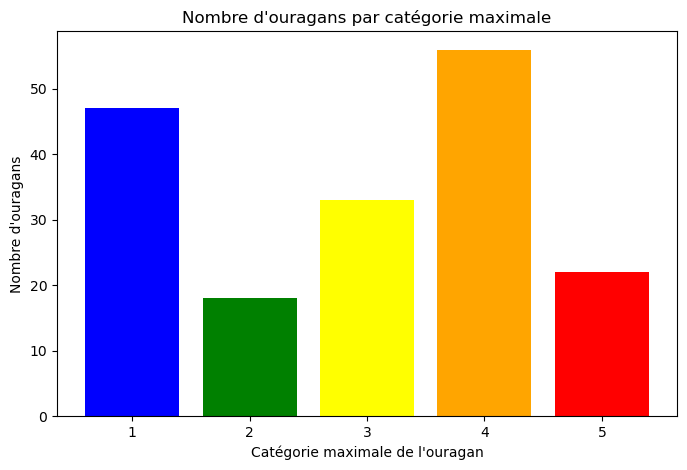

In [38]:
plt.figure(figsize=(8,5))
plt.bar(hurricane_counts.index, hurricane_counts.values, color=['blue', 'green', 'yellow', 'orange', 'red'])
plt.xlabel("Catégorie maximale de l'ouragan")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par catégorie maximale")

plt.show()

In [39]:
df2_copy[df2_copy['name'] == 'Marco']

,name,year,month,day,hour,lat,long,status,category,wind,pressure
6281,Marco,1996,11,20,6,13.8,-78.5,hurricane,1.0,65,983
6282,Marco,1996,11,20,12,14.2,-77.8,hurricane,1.0,65,989
17917,Marco,2020,8,23,12,24.3,-87.2,hurricane,1.0,65,991
17918,Marco,2020,8,23,18,25.3,-87.4,hurricane,1.0,65,992


Pour le calcul des durées des ouragans, vu que pour un ouragan il y avait plusieurs lignes (plusieurs enregistrements), il se trouve que certains ouragans (par exemple 'Marco' survenu en 1996), réapparaissait 24 ans plus tard. Le calcul de la durée des ouragans qui réapparaissaient était donc biaisée. C'est pourquoi nous avons décidé :

- De ne considérer en priorité que l'année où l'ouragan a atteint sa catégorie maximale pour calculer la durée de l'ouragan sur cette année
- Lorsque sur toutes les années d'apparition la catégorie de l'ouragan est invariable, nous calculons la somme des durée de l'ouragan sur chaqune de ses années d'apparition
- S'il n'y a qu'une seule année où l'ouragan est apparu, alors on calcule la durée sur le moment où il a atteint sa catégorie maximale car si on ne le fait pas, cela faussera les calculs de la durée des ouragans de catégorie inférieure

In [40]:
df2_copy['date'] = pd.to_datetime(df2_copy[['year', 'month', 'day']])

#On cherche l'année où chaque ouragan a atteint sa catégorie maximale
max_category_per_hurricane = df2_copy.groupby(['name'])['category'].max().reset_index()

#On associe ces catégories maximales au dataset d'origine
df2_copy = df2_copy.merge(max_category_per_hurricane, on='name', suffixes=('', '_max'))

#On filtre les lignes où l'ouragan est à sa catégorie maximale
df_max_category = df2_copy[df2_copy['category'] == df2_copy['category_max']]

#On calcule la durée de chaque ouragan par année où il a atteint sa catégorie max
hurricane_duration_at_max = df_max_category.groupby(['name', 'year'])['date'].agg(lambda x: (x.max() - x.min()).days + 1).reset_index()

#Si un ouragan atteint sa catégorie max sur plusieurs années, on somme les durées
final_durations = hurricane_duration_at_max.groupby('name')['date'].sum().reset_index()
final_durations.rename(columns={'date': 'duration_at_max_category'}, inplace=True)

#On ajoute la catégorie maximale pour chaque ouragan
final_durations = final_durations.merge(max_category_per_hurricane, on='name')

final_durations

,name,duration_at_max_category,category
0,AL121991,2,1.0
1,Alberto,2,3.0
2,Alex,1,3.0
3,Alicia,1,3.0
4,Allen,5,5.0
...,...,...,...
171,Teddy,2,4.0
172,Tomas,2,2.0
173,Vince,1,1.0
174,Wilma,1,5.0


In [41]:
cat_per_max_duration = final_durations.groupby('category', as_index=False)['duration_at_max_category'].mean()
cat_per_max_duration

,category,duration_at_max_category
0,1.0,3.702128
1,2.0,1.944444
2,3.0,2.090909
3,4.0,2.571429
4,5.0,2.318182


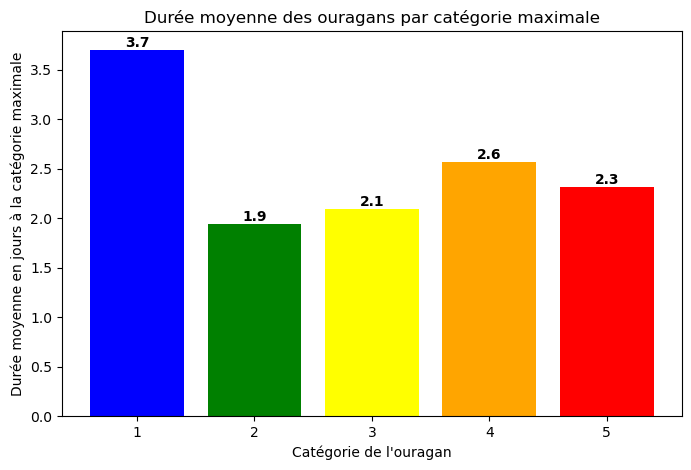

In [42]:
plt.figure(figsize=(8, 5))
bars = plt.bar(cat_per_max_duration['category'], cat_per_max_duration['duration_at_max_category'], 
               color=['blue', 'green', 'yellow', 'orange', 'red'])

#On ajoute les valeurs au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Catégorie de l'ouragan")
plt.ylabel("Durée moyenne en jours à la catégorie maximale")
plt.title("Durée moyenne des ouragans par catégorie maximale")
plt.xticks(cat_per_max_duration['category']) 

plt.show()

In [43]:
duree_cat1 = cat_per_max_duration.at[0, 'duration_at_max_category']
duree_cat5 = cat_per_max_duration.at[4, 'duration_at_max_category']
diff_jours_cat1_cat5 = duree_cat1 - duree_cat5
print("En moyenne, un ouragan de catégorie 1 dure ", diff_jours_cat1_cat5, " jour(s) de plus qu’un ouragan de catégorie 5")

En moyenne, un ouragan de catégorie 1 dure  1.3839458413926495  jour(s) de plus qu’un ouragan de catégorie 5


De plus, on remarque que les ouragans de catégorie 2 durent en moyenne moins longtemps que les ouragans de catégorie 3, qui eux-mêmes durent en moyenne moins logtemps que ceux de catégorie 4

### **3-2-Quelle est la période de l’année la plus propice aux ouragans ?**

Pour répondre à cette question, on commence par regarder pour chaque ouragan, quels sont leur mois d'apparition.

In [44]:
hurricane_months = df2_copy.groupby('name')['month'].unique().reset_index()
hurricane_months.columns = ['name', 'active_months']
hurricane_months

,name,active_months
0,AL121991,[11]
1,Alberto,"[6, 8]"
2,Alex,"[8, 6, 7, 1]"
3,Alicia,[8]
4,Allen,[8]
...,...,...
171,Teddy,[9]
172,Tomas,"[10, 11]"
173,Vince,[10]
174,Wilma,[10]


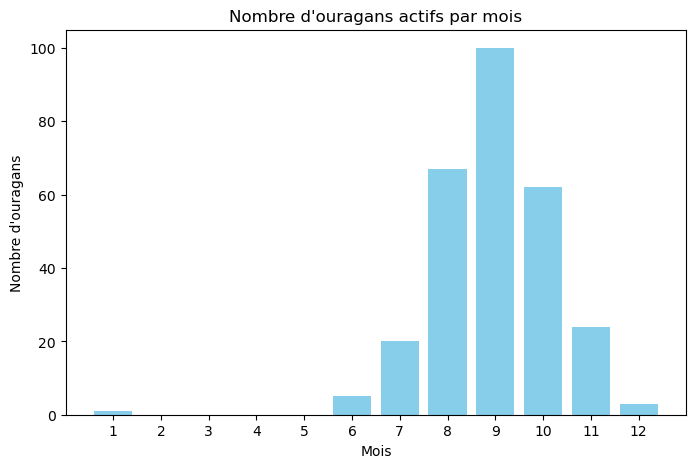

In [45]:
#On convertit les listes en un seul tableau
all_months = np.concatenate(hurricane_months['active_months'].values)  

#On compte le nombre d'occurrences
month_counts = pd.Series(all_months).value_counts().sort_index() 

plt.figure(figsize=(8, 5))
plt.bar(month_counts.index, month_counts.values, color='skyblue')

plt.xlabel("Mois")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans actifs par mois")
plt.xticks(range(1, 13))  # Afficher les mois de 1 à 12

plt.show()

On remarque que les mois d'activités des ouragans sont 'Janvier', puis de 'Juin' à 'Décembre' avec un pic d'activité en 'Septembre'.

En revanche de 'Février' à 'Mai', on observe aucune activité d'ouragan.

In [46]:
#Fonction qui attribue une saison à chaque mois
def get_season(months):
    seasons = []
    for month in months:
        if month in [12, 1, 2]:
            seasons.append("Hiver")
        elif month in [3, 4, 5]:
            seasons.append("Printemps")
        elif month in [6, 7, 8]:
            seasons.append("Été")
        elif month in [9, 10, 11]:
            seasons.append("Automne")
    return list(set(seasons))  # Éviter les doublons

hurricane_months['season'] = hurricane_months['active_months'].apply(get_season)

In [47]:
hurricane_months

,name,active_months,season
0,AL121991,[11],[Automne]
1,Alberto,"[6, 8]",[Été]
2,Alex,"[8, 6, 7, 1]","[Été, Hiver]"
3,Alicia,[8],[Été]
4,Allen,[8],[Été]
...,...,...,...
171,Teddy,[9],[Automne]
172,Tomas,"[10, 11]",[Automne]
173,Vince,[10],[Automne]
174,Wilma,[10],[Automne]


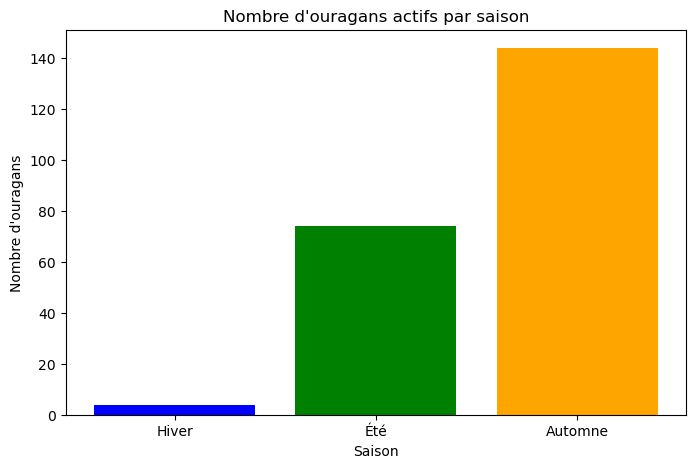

In [48]:
#On fusionne toutes les listes de saisons
all_seasons = np.concatenate(hurricane_months['season'].values)

#On compter les occurrences pour éviter les doublons
season_counts = pd.Series(all_seasons).value_counts().sort_values()

plt.figure(figsize=(8, 5))
plt.bar(season_counts.index, season_counts.values, color=['blue', 'green', 'orange', 'red'])

plt.xlabel("Saison")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans actifs par saison")

plt.show()

On remarque que les ouragans apparaissent beaucoup plus en 'Automne', moins en 'Été', encore moins en 'Hiver', et jamais au 'Printemps'.

### **3-3-Prédire la catégorie maximale que peut atteindre un ouragan lors de son activité**

Nous souhaitons créer un modèle capable de prédire la catégorie maximale qu'un ouragan peut atteindre compte tenu de sa durée dans le temps, son mois et sa saison d'apparition

In [49]:
hurricane_months

,name,active_months,season
0,AL121991,[11],[Automne]
1,Alberto,"[6, 8]",[Été]
2,Alex,"[8, 6, 7, 1]","[Été, Hiver]"
3,Alicia,[8],[Été]
4,Allen,[8],[Été]
...,...,...,...
171,Teddy,[9],[Automne]
172,Tomas,"[10, 11]",[Automne]
173,Vince,[10],[Automne]
174,Wilma,[10],[Automne]


L'on se rend compte que dans hurricane_months, la colonne 'active_months' contient tous les mois d'apparition de l'ouragan. Nous ne voulons garder qu'un seul. Alors nous décidons de garder le mois pendant lequel l'ouragan atteint sa catégorie maximale.

In [50]:
# Pour chaque ouragan, on trouve la ligne où il a atteint sa catégorie maximale
max_category_month = df2_copy.loc[df2_copy.groupby('name')['category'].idxmax()][['name', 'month', 'category']]

# Renommer la colonne 'month' pour clarifier qu'il s'agit du mois où la catégorie maximale est atteinte
max_category_month.columns = ['name', 'month_at_max_category', 'category']

# Afficher le résultat
max_category_month

,name,month_at_max_category,category
1171,AL121991,11,1.0
2182,Alberto,8,3.0
2597,Alex,8,3.0
560,Alicia,8,3.0
297,Allen,8,5.0
...,...,...,...
4473,Teddy,9,4.0
3479,Tomas,10,2.0
2946,Vince,10,1.0
2950,Wilma,10,5.0


In [51]:
def get_season_at_max_category(month):
    season = "nothing"
    if month in [12, 1, 2]:
        season = "Hiver"
    elif month in [3, 4, 5]:
        season = "Printemps"
    elif month in [6, 7, 8]:
        season = "Été"
    elif month in [9, 10, 11]:
        season = "Automne"
    return season  # Éviter les doublons

In [52]:
max_category_month['season'] = max_category_month['month_at_max_category'].apply(get_season_at_max_category)
max_category_month

,name,month_at_max_category,category,season
1171,AL121991,11,1.0,Automne
2182,Alberto,8,3.0,Été
2597,Alex,8,3.0,Été
560,Alicia,8,3.0,Été
297,Allen,8,5.0,Été
...,...,...,...,...
4473,Teddy,9,4.0,Automne
3479,Tomas,10,2.0,Automne
2946,Vince,10,1.0,Automne
2950,Wilma,10,5.0,Automne


In [53]:
#On fusionne les deux datasets sur la colonne 'name'
df_for_prediction = pd.merge(max_category_month, final_durations, on=['name', 'category'], how='inner')
df_for_prediction

,name,month_at_max_category,category,season,duration_at_max_category
0,AL121991,11,1.0,Automne,2
1,Alberto,8,3.0,Été,2
2,Alex,8,3.0,Été,1
3,Alicia,8,3.0,Été,1
4,Allen,8,5.0,Été,5
...,...,...,...,...,...
171,Teddy,9,4.0,Automne,2
172,Tomas,10,2.0,Automne,2
173,Vince,10,1.0,Automne,1
174,Wilma,10,5.0,Automne,1


L'on entraine nos données avec 3 modèles 'RandomForestClassifier', 'XGBClassifier' et 'SVM' plus précisément 'SVC'

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Les données
features = df_for_prediction[['season', 'duration_at_max_category', 'month_at_max_category']]  # On prend les features pertinentes
labels = df_for_prediction['category']  # La cible à prédire

#On transforme les features catégoriques en numériques
features = pd.get_dummies(features)

#On sépare les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

#Évaluation du modèle
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.21      0.43      0.29         7
         2.0       0.25      0.17      0.20         6
         3.0       0.22      0.29      0.25         7
         4.0       0.71      0.38      0.50        13
         5.0       0.00      0.00      0.00         3

    accuracy                           0.31        36
   macro avg       0.28      0.25      0.25        36
weighted avg       0.38      0.31      0.32        36



In [55]:
import xgboost as xgb

#Remappage des classes pour qu'elles commencent à 0
labels = labels - 1

#On sépare les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#Création et entraînement du modèle XGBoost
model_xgb = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
model_xgb.fit(X_train, y_train)

#Prédiction sur l'ensemble de test
y_pred_xgb = model_xgb.predict(X_test)

# Évaluation du modèle
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification Report XGBoost:
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31         7
         1.0       1.00      0.17      0.29         6
         2.0       0.20      0.29      0.24         7
         3.0       0.53      0.69      0.60        13
         4.0       0.00      0.00      0.00         3

    accuracy                           0.39        36
   macro avg       0.41      0.29      0.29        36
weighted avg       0.46      0.39      0.37        36



In [56]:
from sklearn.svm import SVC

#On sépare les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#Création et entraînement du modèle SVM avec des classes déséquilibrées
model_svm = SVC(class_weight='balanced', random_state=42)
model_svm.fit(X_train, y_train)

#Prédiction sur l'ensemble de test
y_pred_svm = model_svm.predict(X_test)

#Évaluation du modèle
print("Classification Report SVM:")
print(classification_report(y_test, y_pred_svm))

Classification Report SVM:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.17      0.67      0.28         6
         2.0       0.17      0.14      0.15         7
         3.0       0.50      0.08      0.13        13
         4.0       0.00      0.00      0.00         3

    accuracy                           0.17        36
   macro avg       0.17      0.18      0.11        36
weighted avg       0.24      0.17      0.12        36



On remarque que le modèle 'XGBClassifier' est celui qui a la meilleure performance (accuracy) : $39$%

Ci-dessous sa matrice de confusion

Classification Report XGBoost:
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31         7
         1.0       1.00      0.17      0.29         6
         2.0       0.20      0.29      0.24         7
         3.0       0.53      0.69      0.60        13
         4.0       0.00      0.00      0.00         3

    accuracy                           0.39        36
   macro avg       0.41      0.29      0.29        36
weighted avg       0.46      0.39      0.37        36



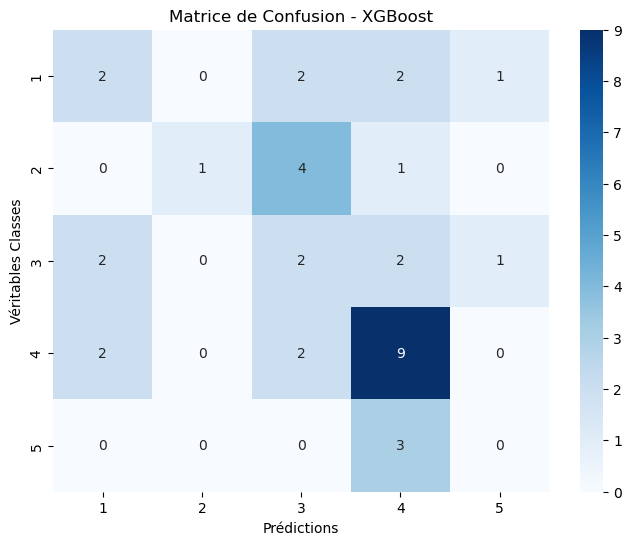

In [57]:
from sklearn.metrics import confusion_matrix
#Évaluation du modèle
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred_xgb))

#Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

#Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de Confusion - XGBoost')
plt.xlabel('Prédictions')
plt.ylabel('Véritables Classes')
plt.show()

Cela semble très mauvais en terme de performance de prédiction. Seuls les catégories 4 ont un bon taux de prédiction.
Nous souhaitons améliorer sa performance.

In [58]:
hurricane_counts

category
1.0    47
2.0    18
3.0    33
4.0    56
5.0    22
Name: count, dtype: int64

Nos données sont mal distribuées. Il y a un déséquilibre des classes (catégories d'ouragan), ce qui constitue un frein au bon apprentissage de notre modèle. Alors pour régler ce souci, nous utilisons l'outil **SMOTE** pour équilibrer nos données (suréchantillonnage des catégories minoritaires et sous-échantillonnage des catégories majoritaires)

In [59]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [60]:
from imblearn.over_sampling import SMOTE

#On sépare les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#On applique SMOTE uniquement sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier le nombre d'échantillons après SMOTE
import pandas as pd
print(pd.Series(y_train_resampled).value_counts())

category
3.0    43
4.0    43
1.0    43
0.0    43
2.0    43
Name: count, dtype: int64


Maintenant que nos données sont équilibrées, on refait l'entrainement(avec plusieurs hyperparamètres cette fois) et on affiche une matrice de confusion.

Classification Report XGBoost:
              precision    recall  f1-score   support

         0.0       0.50      0.14      0.22         7
         1.0       0.40      0.33      0.36         6
         2.0       0.15      0.29      0.20         7
         3.0       0.40      0.31      0.35        13
         4.0       0.00      0.00      0.00         3

    accuracy                           0.25        36
   macro avg       0.29      0.21      0.23        36
weighted avg       0.34      0.25      0.27        36



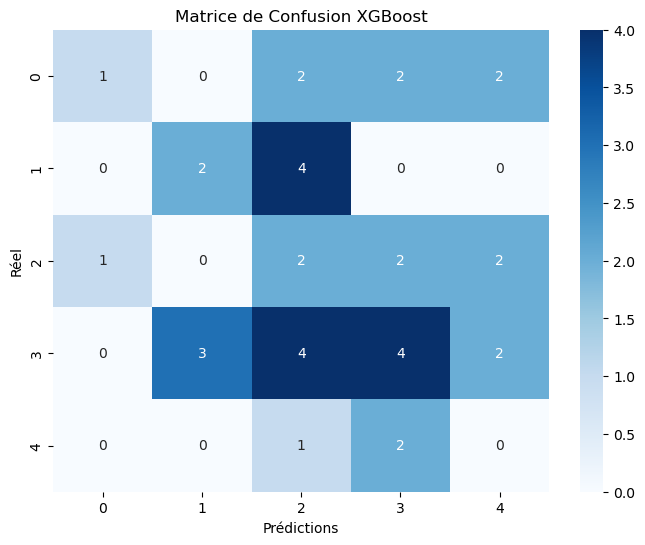

In [74]:
from sklearn.utils import class_weight
#Calcul des poids par classe en fonction de la fréquence des classes dans y_train_resampled
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_resampled)

#Entraînement du modèle XGBoost avec les poids
model_xgb = xgb.XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

model_xgb.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

#Prédiction sur l'ensemble de test
y_pred_xgb = model_xgb.predict(X_test)

#Évaluation du modèle
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred_xgb))

#Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

#Visualisation de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de Confusion XGBoost')
plt.show()

On observe une amélioration de la performancde de prédiction de notre modèle, même si elle n'est pas au top.

Si améliorées, les prédictions de notre modèle pourraient être utiles dans la prédiction de la catégorie maximale qu'un ouragan peut atteindre compte tenue de sa durée, du mois et de la saison de son apparition. Cela permettrait de mieux anticiper son intensité et préparer des évacuations massives si nécessaire